In [17]:
import sys
sys.executable

'c:\\Users\\USUARIO\\Desktop\\ECO HENO\\.venv\\Scripts\\python.exe'

In [18]:
import sys
!"{sys.executable}" -m pip install setuptools


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import sys
!"{sys.executable}" -m pip install pandas numpy matplotlib seaborn plotly scikit-learn xgboost lightgbm hdbscan umap-learn optuna shap joblib ydata-profiling streamlit pyarrow tqdm requests python-dateutil onnx ipywidgets


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
%matplotlib inline

In [21]:
# Cargar las librería de requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import onnx
import dateutil as du
from tqdm import tqdm
import requests as rq
import seaborn as sns
import plotly.express as px
import sklearn
import xgboost as xgb
import lightgbm as lgb
import hdbscan as hdb
import umap
import optuna as opt
import shap
import joblib as jb
import ydata_profiling as yp
import streamlit as st
import pyarrow as pa



In [22]:
# CARGAR BASE DE DATOS BASE ECO HENO
df = pd.read_excel('BASE_ECO_HENO_F.xlsx')

# FASE 1

## 1.1 Unificar el Excel en formato “largo”

In [24]:
# 1) Unificar los 4 bloques en formato largo
base_cols = ["AÑO", "MES", "DÍAS", "FECHA COMPLETA"]
suffixes = ["", ".1", ".2", ".3"]

bloques = []
for suf in suffixes:
    act   = f"ACTIVIDAD DEL DÍA SECTOR{suf}"
    sec   = f"SECTOR{suf}"
    notas = f"NOTAS{suf}"
    prod  = f"PRODUCCION DE HENO SECTOR{suf}"

    # Validación de que existan las columnas esenciales del bloque
    if sec in df.columns and act in df.columns:
        cols = base_cols + [act, sec]

        tmp = df[cols].copy()

        # NOTAS (si no existe, se crea vacía)
        tmp["NOTAS"] = df[notas] if notas in df.columns else np.nan

        # PRODUCCIÓN (si no existe, se crea vacía)
        tmp["PRODUCCION_HENO"] = df[prod] if prod in df.columns else np.nan

        # Renombrar a nombres estándar
        tmp = tmp.rename(columns={act: "ACTIVIDAD", sec: "SECTOR"})

        bloques.append(tmp)

df_unificada = pd.concat(bloques, ignore_index=True)

# 2) Limpieza mínima y tipos
df_unificada["FECHA COMPLETA"] = pd.to_datetime(df_unificada["FECHA COMPLETA"], errors="coerce")
df_unificada["SECTOR"] = pd.to_numeric(df_unificada["SECTOR"], errors="coerce")
df_unificada["PRODUCCION_HENO"] = pd.to_numeric(df_unificada["PRODUCCION_HENO"], errors="coerce")

# eliminar filas sin sector o sin fecha (opcional, pero recomendado para proceso)
df_unificada = df_unificada.dropna(subset=["SECTOR", "FECHA COMPLETA"]).copy()
df_unificada["SECTOR"] = df_unificada["SECTOR"].astype(int)

# 3) Checkpoint solicitado
print("df_unificada.shape:", df_unificada.shape)
print("Columnas disponibles:", list(df_unificada.columns))

faltantes = [c for c in ["SECTOR", "FECHA COMPLETA", "ACTIVIDAD", "PRODUCCION_HENO", "NOTAS"] if c not in df_unificada.columns]
print("Columnas mínimas faltantes:", faltantes)

print("\nMuestra de datos:")
print(df_unificada[["SECTOR", "FECHA COMPLETA", "ACTIVIDAD", "PRODUCCION_HENO", "NOTAS"]].head(10))

df_unificada.shape: (605, 8)
Columnas disponibles: ['AÑO', 'MES', 'DÍAS', 'FECHA COMPLETA', 'ACTIVIDAD', 'SECTOR', 'NOTAS', 'PRODUCCION_HENO']
Columnas mínimas faltantes: []

Muestra de datos:
   SECTOR FECHA COMPLETA        ACTIVIDAD  PRODUCCION_HENO  \
0       1     2022-01-03            CORTE      7525.480000   
1       1     2022-01-04   SECADO – Día 1      6324.640000   
2       1     2022-01-05   SECADO – Día 2      5788.900000   
3       1     2022-01-06   VOLTEO – Día 1      5424.520000   
4       1     2022-01-07   VOLTEO – Día 2      5193.500000   
5       1     2022-01-08  Empaque – Día 1       831.411667   
6       1     2022-01-11  Empaque – Día 2       775.599235   
7       1     2022-01-12  Empaque – Día 3       831.411667   
8       1     2022-01-13  Empaque – Día 4       831.411667   
9       1     2022-01-14  Empaque – Día 5       831.411667   

                   NOTAS  
0         BIOMASA FRESCA  
1      REDUCCION SECADOS  
2      REDUCCION SECADOS  
3      REDUCCION

## 1.2 Normalizar ACTIVIDAD y crear ACTIVIDAD_NORM

In [25]:
df_unificada["ACTIVIDAD_NORM"] = (
    df_unificada["ACTIVIDAD"]
    .astype(str)              # protege contra NaN
    .str.upper()              # todo en mayúsculas
    .str.replace("–", "-", regex=False)
    .str.replace("—", "-", regex=False)
    .str.replace("Á", "A", regex=False)
    .str.replace("É", "E", regex=False)
    .str.replace("Í", "I", regex=False)
    .str.replace("Ó", "O", regex=False)
    .str.replace("Ú", "U", regex=False)
    .str.strip()
)

In [26]:
# Ver primeras filas normalizadas
df_unificada["ACTIVIDAD_NORM"].head(10)


0              CORTE
1     SECADO - DIA 1
2     SECADO - DIA 2
3     VOLTEO - DIA 1
4     VOLTEO - DIA 2
5    EMPAQUE - DIA 1
6    EMPAQUE - DIA 2
7    EMPAQUE - DIA 3
8    EMPAQUE - DIA 4
9    EMPAQUE - DIA 5
Name: ACTIVIDAD_NORM, dtype: object

In [27]:
# Verificar que no sea todo NaN
df_unificada["ACTIVIDAD_NORM"].isna().sum(), df_unificada.shape[0]


(np.int64(0), 605)

## 1.3 — Crear la variable ETAPA

In [28]:
df_unificada["ETAPA"] = np.select(
    [
        df_unificada["ACTIVIDAD_NORM"].str.contains("CORTE", na=False),
        df_unificada["ACTIVIDAD_NORM"].str.contains("SECAD", na=False),
        df_unificada["ACTIVIDAD_NORM"].str.contains("VOLT",  na=False),
        df_unificada["ACTIVIDAD_NORM"].str.contains("EMPAQ", na=False),
    ],
    ["CORTE", "SECADO", "VOLTEO", "EMPAQUE"],
    default="OTRA/NO CLASIFICADA"
)

In [29]:
df_unificada["ETAPA"].value_counts(dropna=False)


ETAPA
EMPAQUE                288
SECADO                 123
VOLTEO                 109
CORTE                   64
OTRA/NO CLASIFICADA     21
Name: count, dtype: int64

In [30]:
df_unificada[["ACTIVIDAD_NORM", "ETAPA"]].head(15)


,ACTIVIDAD_NORM,ETAPA
0,CORTE,CORTE
1,SECADO - DIA 1,SECADO
2,SECADO - DIA 2,SECADO
3,VOLTEO - DIA 1,VOLTEO
4,VOLTEO - DIA 2,VOLTEO
5,EMPAQUE - DIA 1,EMPAQUE
6,EMPAQUE - DIA 2,EMPAQUE
7,EMPAQUE - DIA 3,EMPAQUE
8,EMPAQUE - DIA 4,EMPAQUE
9,EMPAQUE - DIA 5,EMPAQUE


## 1.4 — Extraer DIA_EMPAQUE

In [31]:
df_unificada["DIA_EMPAQUE"] = (
    df_unificada["ACTIVIDAD_NORM"]
    .str.extract(r"DIA\s*(\d+)", expand=False)
    .astype(float)
)

In [32]:
# Verificar valores extraídos
df_unificada[df_unificada["ETAPA"] == "EMPAQUE"][["ACTIVIDAD_NORM", "DIA_EMPAQUE"]].head(15)


,ACTIVIDAD_NORM,DIA_EMPAQUE
5,EMPAQUE - DIA 1,1.0
6,EMPAQUE - DIA 2,2.0
7,EMPAQUE - DIA 3,3.0
8,EMPAQUE - DIA 4,4.0
9,EMPAQUE - DIA 5,5.0
10,EMPAQUE - DIA 6,6.0
17,EMPAQUE - DIA 1,1.0
18,EMPAQUE - DIA 2,2.0
19,EMPAQUE - DIA 3,3.0
20,EMPAQUE - DIA 4,4.0


In [33]:
# Distribución de días de empaque
df_unificada[df_unificada["ETAPA"] == "EMPAQUE"]["DIA_EMPAQUE"].value_counts().sort_index()


DIA_EMPAQUE
1.0    48
2.0    48
3.0    48
4.0    48
5.0    48
6.0    48
Name: count, dtype: int64

# FASE 2 — Entender el proceso (EDA del sistema)

## 2.1 — Verificación temporal básica

In [34]:
df_unificada["FECHA COMPLETA"].min(), df_unificada["FECHA COMPLETA"].max()


(Timestamp('2022-01-03 00:00:00'), Timestamp('2025-02-03 00:00:00'))

## 2.2 — Conteo por sector y etapa

In [35]:
df_unificada.groupby(["SECTOR", "ETAPA"]).size().unstack(fill_value=0)


ETAPA,CORTE,EMPAQUE,OTRA/NO CLASIFICADA,SECADO,VOLTEO
SECTOR,,,,,
1,9,42,2,18,17
2,9,42,3,18,16
3,9,42,3,17,14
4,9,42,4,17,17
5,7,30,2,14,14
6,7,30,1,14,11
7,7,30,3,14,10
8,7,30,3,11,10


## 2.3 — Producción por etapa (visión general)

In [36]:
df_unificada.groupby("ETAPA")["PRODUCCION_HENO"].describe()


,count,mean,std,min,25%,50%,75%,max
ETAPA,,,,,,,,
CORTE,61.0,7250.383770,835.163718,6017.080000,6570.290000,7175.440000,7960.640000,8959.460000
EMPAQUE,288.0,703.542884,128.320957,188.009256,630.683333,714.263833,804.490083,946.443333
OTRA/NO CLASIFICADA,19.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SECADO,119.0,5256.105966,1443.027961,0.000000,4832.180000,5373.270000,6028.815000,7505.820000
VOLTEO,107.0,4486.607477,1339.992893,0.000000,4181.310000,4656.400000,5270.130000,6115.310000


## 2.4 — Confirmar decisión metodológica

In [37]:
df_unificada[df_unificada["ETAPA"] == "EMPAQUE"][
    ["SECTOR", "FECHA COMPLETA", "DIA_EMPAQUE", "PRODUCCION_HENO"]
].sort_values(["SECTOR", "FECHA COMPLETA", "DIA_EMPAQUE"]).head(20)


,SECTOR,FECHA COMPLETA,DIA_EMPAQUE,PRODUCCION_HENO
5,1,2022-01-08,1.0,831.411667
6,1,2022-01-11,2.0,775.599235
7,1,2022-01-12,3.0,831.411667
8,1,2022-01-13,4.0,831.411667
9,1,2022-01-14,5.0,831.411667
10,1,2022-01-15,6.0,831.411667
220,1,2022-09-27,1.0,852.363298
221,1,2022-09-28,2.0,850.094054
222,1,2022-09-29,3.0,854.630800
223,1,2022-09-30,4.0,901.938333


# FASE 3 — Construcción de ciclos reales

## 3.1 — Ordenar el dataset

In [38]:
df_unificada = df_unificada.sort_values(
    ["SECTOR", "FECHA COMPLETA"]
)


## 3.2 — Crear tabla de cortes

In [39]:
df_cortes = (
    df_unificada[df_unificada["ETAPA"] == "CORTE"]
    [["SECTOR", "FECHA COMPLETA", "PRODUCCION_HENO"]]
    .rename(columns={
        "FECHA COMPLETA": "FECHA_CORTE",
        "PRODUCCION_HENO": "PROD_CORTE"
    })
    .sort_values(["SECTOR", "FECHA_CORTE"])
)


## 3.3 — Crear tabla de empaques finales

In [40]:
df_empaque_final = (
    df_unificada[df_unificada["ETAPA"] == "EMPAQUE"]
    .sort_values(["SECTOR", "FECHA COMPLETA", "DIA_EMPAQUE"])
    .groupby(["SECTOR", "FECHA COMPLETA"], as_index=False)
    .last()
    [["SECTOR", "FECHA COMPLETA", "PRODUCCION_HENO", "DIA_EMPAQUE"]]
    .rename(columns={
        "FECHA COMPLETA": "FECHA_EMPAQUE_FINAL",
        "PRODUCCION_HENO": "PROD_FINAL",
        "DIA_EMPAQUE": "DIA_FINAL"
    })
)


## 3.4 — Reconstruir ciclos

In [41]:
df_modelo = pd.merge_asof(
    df_empaque_final.sort_values("FECHA_EMPAQUE_FINAL"),
    df_cortes.sort_values("FECHA_CORTE"),
    left_on="FECHA_EMPAQUE_FINAL",
    right_on="FECHA_CORTE",
    by="SECTOR",
    direction="backward"
)


## 3.5 — Limpiar posibles casos sin corte

In [42]:
df_modelo = df_modelo.dropna(subset=["PROD_CORTE"]).copy()


## CHECKPOINT

In [43]:
df_modelo.shape


(288, 6)

In [44]:
(df_modelo["FECHA_EMPAQUE_FINAL"] > df_modelo["FECHA_CORTE"]).mean()


np.float64(1.0)

In [45]:
df_modelo[["PROD_CORTE","PROD_FINAL"]].describe()


,PROD_CORTE,PROD_FINAL
count,288.000000,288.000000
mean,7318.580417,703.542884
std,871.190996,128.320957
min,6017.080000,188.009256
25%,6546.215000,630.683333
50%,7358.520000,714.263833
75%,7999.367500,804.490083
max,8959.460000,946.443333


In [46]:
df_modelo[["PROD_CORTE", "PROD_FINAL"]].corr()


,PROD_CORTE,PROD_FINAL
PROD_CORTE,1.000000,0.721891
PROD_FINAL,0.721891,1.000000


# FASE 4 — Modelado

## 4.1 — Crear variables para el modelo

In [47]:
df_modelo["MES"] = df_modelo["FECHA_CORTE"].dt.month
df_modelo["AÑO"] = df_modelo["FECHA_CORTE"].dt.year


## 4.2 — Definir dataset de entrenamiento

In [48]:
features = [
    "PROD_CORTE",
    "DIA_FINAL",
    "SECTOR",
    "MES"
]

X = df_modelo[features]
y = df_modelo["PROD_FINAL"]


## 4.3 — Train / Test split

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


## 4.4 — Entrenar el modelo base

In [50]:
from sklearn.ensemble import RandomForestRegressor

modelo = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

modelo.fit(X_train, y_train)


,n_estimators,400
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 4.5 — Evaluación REAL

In [52]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Predicción
y_pred = modelo.predict(X_test)

# Métricas
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print("RESULTADOS DEL MODELO")
print("----------------------")
print(f"R2   : {r2:.4f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")


RESULTADOS DEL MODELO
----------------------
R2   : 0.7495
MSE  : 3750.64
RMSE : 61.24
MAE  : 37.48


In [53]:
importancias = pd.Series(
    modelo.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importancias

PROD_CORTE    0.716796
DIA_FINAL     0.125570
SECTOR        0.082427
MES           0.075208
dtype: float64

In [54]:
from sklearn.metrics import r2_score

train_pred = modelo.predict(X_train)

r2_train = r2_score(y_train, train_pred)
r2_test = r2_score(y_test, y_pred)

r2_train, r2_test


(0.9674824585199925, 0.7495409723170656)

In [56]:
def predecir_produccion(prod_corte, dia_final, sector, mes):
    
    datos = pd.DataFrame({
        "PROD_CORTE": [prod_corte],
        "DIA_FINAL": [dia_final],
        "SECTOR": [sector],
        "MES": [mes]
    })
    
    pred = modelo.predict(datos)[0]
    
    return round(pred, 2)


In [57]:
predecir_produccion(
    prod_corte=7500,
    dia_final=5,
    sector=3,
    mes=6
)


np.float64(684.69)

In [58]:
def simular_dias(prod_corte, sector, mes):
    
    resultados = []
    
    for dia in range(1,7):
        
        datos = pd.DataFrame({
            "PROD_CORTE":[prod_corte],
            "DIA_FINAL":[dia],
            "SECTOR":[sector],
            "MES":[mes]
        })
        
        pred = modelo.predict(datos)[0]
        
        resultados.append((dia, round(pred,2)))
        
    return pd.DataFrame(resultados, columns=["Dia_Empaque","Produccion_Predicha"])


In [59]:
simular_dias(7500, sector=3, mes=6)


,Dia_Empaque,Produccion_Predicha
0,1,765.68
1,2,737.34
2,3,728.40
3,4,701.34
4,5,684.69
5,6,613.96


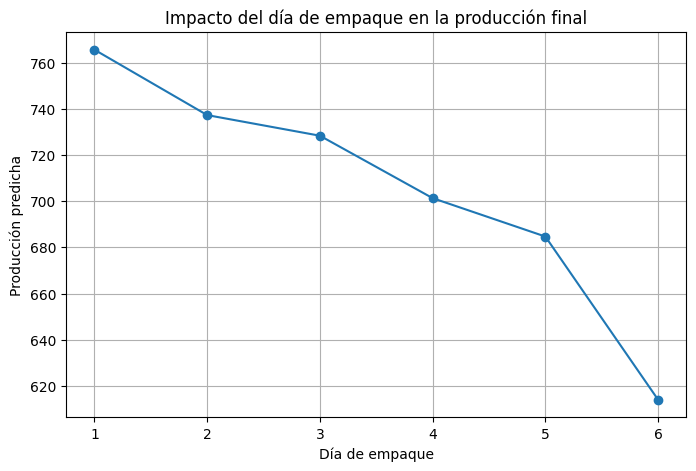

In [60]:
import matplotlib.pyplot as plt

sim = simular_dias(7500, sector=3, mes=6)

plt.figure(figsize=(8,5))

plt.plot(
    sim["Dia_Empaque"],
    sim["Produccion_Predicha"],
    marker="o"
)

plt.title("Impacto del día de empaque en la producción final")
plt.xlabel("Día de empaque")
plt.ylabel("Producción predicha")

plt.grid(True)
plt.show()


In [61]:
sim["Perdida_vs_dia1"] = sim["Produccion_Predicha"].iloc[0] - sim["Produccion_Predicha"]

sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1
0,1,765.68,0.00
1,2,737.34,28.34
2,3,728.40,37.28
3,4,701.34,64.34
4,5,684.69,80.99
5,6,613.96,151.72


In [62]:
sim["Perdida_%"] = (
    sim["Perdida_vs_dia1"] /
    sim["Produccion_Predicha"].iloc[0]
) * 100

sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%
0,1,765.68,0.00,0.000000
1,2,737.34,28.34,3.701285
2,3,728.40,37.28,4.868875
3,4,701.34,64.34,8.402988
4,5,684.69,80.99,10.577526
5,6,613.96,151.72,19.815066


In [63]:
sim["Marginal_perdida"] = sim["Produccion_Predicha"].diff() * -1
sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida
0,1,765.68,0.00,0.000000,NaN
1,2,737.34,28.34,3.701285,28.34
2,3,728.40,37.28,4.868875,8.94
3,4,701.34,64.34,8.402988,27.06
4,5,684.69,80.99,10.577526,16.65
5,6,613.96,151.72,19.815066,70.73


In [64]:
sim["Elasticidad"] = (
    sim["Produccion_Predicha"].pct_change() /
    sim["Dia_Empaque"].pct_change()
)

sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad
0,1,765.68,0.00,0.000000,NaN,NaN
1,2,737.34,28.34,3.701285,28.34,-0.037013
2,3,728.40,37.28,4.868875,8.94,-0.024249
3,4,701.34,64.34,8.402988,27.06,-0.111450
4,5,684.69,80.99,10.577526,16.65,-0.094961
5,6,613.96,151.72,19.815066,70.73,-0.516511


In [65]:
sim["Cambio_elasticidad"] = sim["Elasticidad"].diff().abs()

sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad
0,1,765.68,0.00,0.000000,NaN,NaN,NaN
1,2,737.34,28.34,3.701285,28.34,-0.037013,NaN
2,3,728.40,37.28,4.868875,8.94,-0.024249,0.012764
3,4,701.34,64.34,8.402988,27.06,-0.111450,0.087200
4,5,684.69,80.99,10.577526,16.65,-0.094961,0.016489
5,6,613.96,151.72,19.815066,70.73,-0.516511,0.421550


In [66]:
sim.sort_values("Cambio_elasticidad", ascending=False)


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad
5,6,613.96,151.72,19.815066,70.73,-0.516511,0.421550
3,4,701.34,64.34,8.402988,27.06,-0.111450,0.087200
4,5,684.69,80.99,10.577526,16.65,-0.094961,0.016489
2,3,728.40,37.28,4.868875,8.94,-0.024249,0.012764
0,1,765.68,0.00,0.000000,NaN,NaN,NaN
1,2,737.34,28.34,3.701285,28.34,-0.037013,NaN


In [67]:
sim["Eficiencia_marginal"] = sim["Produccion_Predicha"] / sim["Dia_Empaque"]

sim.sort_values("Eficiencia_marginal", ascending=False)


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad,Eficiencia_marginal
0,1,765.68,0.00,0.000000,NaN,NaN,NaN,765.680000
1,2,737.34,28.34,3.701285,28.34,-0.037013,NaN,368.670000
2,3,728.40,37.28,4.868875,8.94,-0.024249,0.012764,242.800000
3,4,701.34,64.34,8.402988,27.06,-0.111450,0.087200,175.335000
4,5,684.69,80.99,10.577526,16.65,-0.094961,0.016489,136.938000
5,6,613.96,151.72,19.815066,70.73,-0.516511,0.421550,102.326667


In [68]:
sim["Caida_eficiencia_%"] = sim["Eficiencia_marginal"].pct_change() * -100
sim


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad,Eficiencia_marginal,Caida_eficiencia_%
0,1,765.68,0.00,0.000000,NaN,NaN,NaN,765.680000,NaN
1,2,737.34,28.34,3.701285,28.34,-0.037013,NaN,368.670000,51.850643
2,3,728.40,37.28,4.868875,8.94,-0.024249,0.012764,242.800000,34.141644
3,4,701.34,64.34,8.402988,27.06,-0.111450,0.087200,175.335000,27.786244
4,5,684.69,80.99,10.577526,16.65,-0.094961,0.016489,136.938000,21.899221
5,6,613.96,151.72,19.815066,70.73,-0.516511,0.421550,102.326667,25.275185


In [69]:
sim_final = sim.copy()
sim_final


,Dia_Empaque,Produccion_Predicha,Perdida_vs_dia1,Perdida_%,Marginal_perdida,Elasticidad,Cambio_elasticidad,Eficiencia_marginal,Caida_eficiencia_%
0,1,765.68,0.00,0.000000,NaN,NaN,NaN,765.680000,NaN
1,2,737.34,28.34,3.701285,28.34,-0.037013,NaN,368.670000,51.850643
2,3,728.40,37.28,4.868875,8.94,-0.024249,0.012764,242.800000,34.141644
3,4,701.34,64.34,8.402988,27.06,-0.111450,0.087200,175.335000,27.786244
4,5,684.69,80.99,10.577526,16.65,-0.094961,0.016489,136.938000,21.899221
5,6,613.96,151.72,19.815066,70.73,-0.516511,0.421550,102.326667,25.275185


In [70]:
import pandas as pd

def predecir_produccion(modelo, prod_corte, dia_final, sector, mes):
    datos = pd.DataFrame({
        "PROD_CORTE": [prod_corte],
        "DIA_FINAL": [dia_final],
        "SECTOR": [sector],
        "MES": [mes]
    })
    return float(modelo.predict(datos)[0])

def simular_dias(modelo, prod_corte, sector, mes):
    resultados = []
    for dia in range(1, 7):
        pred = predecir_produccion(modelo, prod_corte, dia, sector, mes)
        resultados.append((dia, round(pred, 2)))

    sim = pd.DataFrame(resultados, columns=["Dia_Empaque", "Produccion_Predicha"])
    sim["Perdida_vs_dia1"] = sim["Produccion_Predicha"].iloc[0] - sim["Produccion_Predicha"]
    sim["Perdida_%"] = (sim["Perdida_vs_dia1"] / sim["Produccion_Predicha"].iloc[0]) * 100
    sim["Marginal_perdida"] = sim["Produccion_Predicha"].diff() * -1
    sim["Elasticidad"] = sim["Produccion_Predicha"].pct_change() / sim["Dia_Empaque"].pct_change()
    sim["Cambio_elasticidad"] = sim["Elasticidad"].diff().abs()
    sim["Eficiencia_marginal"] = sim["Produccion_Predicha"] / sim["Dia_Empaque"]
    sim["Caida_eficiencia_%"] = sim["Eficiencia_marginal"].pct_change() * -100

    return sim


# PUBLICACIÓN

In [71]:
import joblib

joblib.dump(modelo, "modelo_ecoheno.pkl")

columnas_modelo = list(X.columns)
joblib.dump(columnas_modelo, "columnas_modelo.pkl")


['columnas_modelo.pkl']

In [72]:
import streamlit as st
import pandas as pd
import joblib

st.set_page_config(page_title="EcoHeno - Simulador", layout="centered")

st.title("EcoHeno: Predicción y simulación de producción final")

@st.cache_resource
def cargar_modelo():
    modelo = joblib.load("modelo_ecoheno.pkl")
    columnas = joblib.load("columnas_modelo.pkl")
    return modelo, columnas

def predecir_produccion(modelo, columnas, prod_corte, dia_final, sector, mes):
    df = pd.DataFrame([{
        "PROD_CORTE": prod_corte,
        "DIA_FINAL": dia_final,
        "SECTOR": sector,
        "MES": mes
    }])

    df = df.reindex(columns=columnas)
    pred = modelo.predict(df)[0]
    return float(pred)

def simular_dias(modelo, columnas, prod_corte, sector, mes):
    resultados = []
    for dia in range(1, 7):
        pred = predecir_produccion(modelo, columnas, prod_corte, dia, sector, mes)
        resultados.append((dia, round(pred, 2)))

    sim = pd.DataFrame(resultados, columns=["Dia_Empaque", "Produccion_Predicha"])

    sim["Perdida_vs_dia1"] = sim["Produccion_Predicha"].iloc[0] - sim["Produccion_Predicha"]
    sim["Perdida_%"] = (sim["Perdida_vs_dia1"] / sim["Produccion_Predicha"].iloc[0]) * 100
    sim["Marginal_perdida"] = sim["Produccion_Predicha"].diff() * -1
    sim["Elasticidad"] = sim["Produccion_Predicha"].pct_change() / sim["Dia_Empaque"].pct_change()
    sim["Cambio_elasticidad"] = sim["Elasticidad"].diff().abs()
    sim["Eficiencia_marginal"] = sim["Produccion_Predicha"] / sim["Dia_Empaque"]
    sim["Caida_eficiencia_%"] = sim["Eficiencia_marginal"].pct_change() * -100

    return sim

modelo, columnas = cargar_modelo()

st.sidebar.header("Entradas")

prod_corte = st.sidebar.number_input("Producción en corte (PROD_CORTE)", min_value=0.0, value=7500.0, step=10.0)
sector = st.sidebar.selectbox("Sector", options=list(range(1, 9)), index=2)
mes = st.sidebar.selectbox("Mes", options=list(range(1, 13)), index=5)
dia_final = st.sidebar.selectbox("Día de empaque", options=list(range(1, 7)), index=4)

st.subheader("Predicción puntual")

pred = predecir_produccion(modelo, columnas, prod_corte, dia_final, sector, mes)
st.write(f"Producción final predicha: {pred:.2f}")

st.subheader("Simulación por días 1 a 6")

sim = simular_dias(modelo, columnas, prod_corte, sector, mes)

st.dataframe(sim, use_container_width=True)

st.subheader("Gráfico")

st.line_chart(sim.set_index("Dia_Empaque")["Produccion_Predicha"])

st.subheader("Regla operativa sugerida")

umbral = sim.loc[sim["Cambio_elasticidad"].idxmax(), "Dia_Empaque"]
st.write(f"Mayor cambio de elasticidad detectado en el día: {int(umbral)}")
st.write("Recomendación: evitar operar después del día 5 si el umbral cae en 6.")


2026-01-31 16:50:14.330 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-31 16:50:14.333 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-31 16:50:14.421 
  command:

    streamlit run c:\Users\USUARIO\Desktop\ECO HENO\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2026-01-31 16:50:14.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-31 16:50:14.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-31 16:50:14.424 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-31 16:50:14.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ig